In [1]:
import torch
from vit import ViT
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
image_size = 28
patch_size = 7
channels = 1  # EMNIST is grayscale
num_classes = 62  
batch_size = 16
num_epochs = 15
lr = 3e-4

In [3]:
device = 'cuda'

In [ ]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: transforms.functional.rotate(img, -90)),
    transforms.Lambda(lambda img: transforms.functional.hflip(img)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),  # convert grayscale to 3-channel
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.EMNIST(
    root='./data',
    split='byclass',  
    download=True,
    transform=transform
)
test_dataset = datasets.EMNIST(
    root='./data',
    split='byclass',
    train=False,
    download=True,
    transform=transform
)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [6]:
len(train_dataset.classes)

62

In [7]:
print(f"patches = {(image_size // patch_size) ** 2}")

patches = 16


In [ ]:
torch.cuda.empty_cache() #optional if using a gpu

In [7]:
model = ViT(
    image_size=28,
    patch_size=7,
    num_classes=num_classes,
    dim=256,
    depth=6,
    heads=8,
    mlp_dim=512,
    channels=3,  
    dropout=0.1,
    emb_dropout=0.1
).to(device)

In [29]:
print(model)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=7, p2=7)
    (1): LayerNorm((147,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=147, out_features=256, bias=True)
    (3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=512, out_features=256, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0):

In [ ]:
lossfn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = lossfn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss:.4f} - Accuracy: {100.*correct/total:.2f}%")

Epoch [1/15] - Loss: 27173.9531 - Accuracy: 79.25%


Epoch [2/15] - Loss: 21127.1219 - Accuracy: 82.89%


Epoch [3/15] - Loss: 19455.7806 - Accuracy: 83.93%


Epoch [4/15] - Loss: 18698.2971 - Accuracy: 84.46%


Epoch [5/15] - Loss: 18057.8964 - Accuracy: 84.88%


Epoch [6/15] - Loss: 17552.7616 - Accuracy: 85.17%


Epoch [7/15] - Loss: 17188.5654 - Accuracy: 85.45%


Epoch [8/15] - Loss: 16963.9206 - Accuracy: 85.55%


Epoch [9/15] - Loss: 16777.5650 - Accuracy: 85.69%


Epoch [10/15] - Loss: 16472.5801 - Accuracy: 85.90%


Epoch [11/15] - Loss: 16311.8780 - Accuracy: 86.00%


Epoch [12/15] - Loss: 16238.5189 - Accuracy: 86.06%


Epoch [13/15] - Loss: 16062.1760 - Accuracy: 86.16%


Epoch [14/15] - Loss: 15944.7905 - Accuracy: 86.26%


Epoch [15/15] - Loss: 15795.7723 - Accuracy: 86.36%


In [16]:
from pathlib import Path
ModelPath = Path("models")
ModelPath.mkdir(parents= True,exist_ok= True)

ModelName = "ViT.pth"
ModelSavePath = ModelPath / ModelName   
ModelSavePath

WindowsPath('models/ViT.pth')

In [26]:
torch.save(model.state_dict(), ModelSavePath)

In [12]:
model.load_state_dict(torch.load(ModelSavePath))

<All keys matched successfully>

In [10]:
model.eval()
classes = test_dataset.classes  # class indices

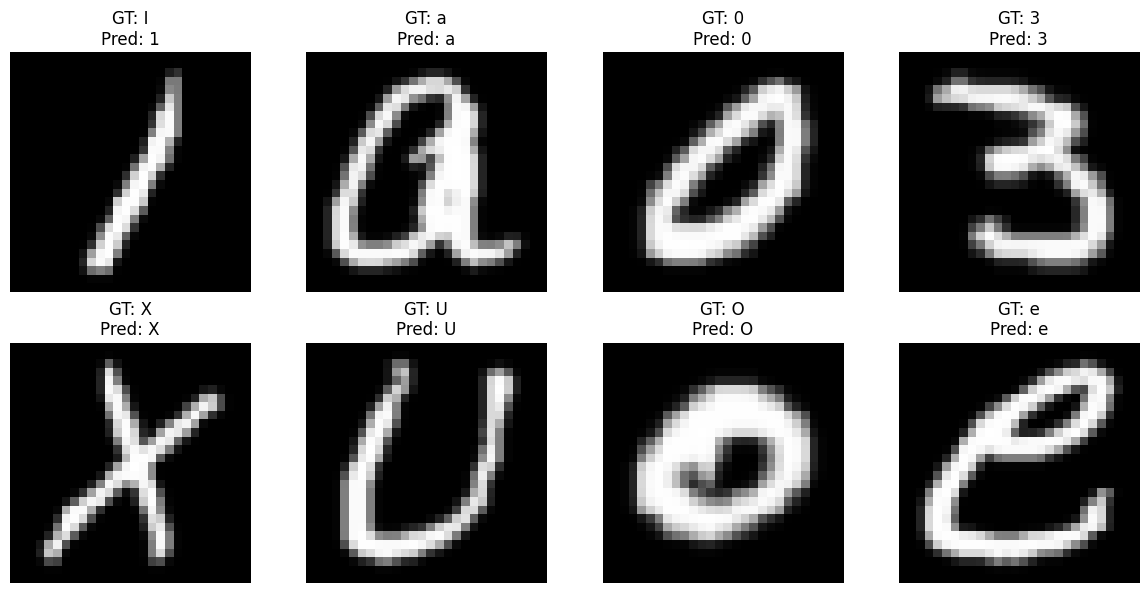

In [24]:
with torch.no_grad():
    images, labels = next(iter(test_loader))
    images, labels = images[:8].to(device), labels[:8].to(device)
    outputs = model(images)
    _, preds = outputs.max(1)

    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(images[idx][0].cpu(), cmap='gray')
        ax.set_title(f"GT: {classes[labels[idx]]}\nPred: {classes[preds[idx]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()



In [12]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [25]:
evaluate_accuracy(model, test_loader, device)

Test Accuracy: 86.65%


86.65096326607808